# Data Science for Business - GAM on Ames Housing

## Initialize notebook
Load required packages. Set up workspace, e.g., set theme for plotting and initialize the random number generator.

In [2]:
# Install packages that are not already installed on Colab
!pip install pygam

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

In [3]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

import statsmodels.formula.api as smf

import pygam
from pygam import LinearGAM, s, l, f, te

In [4]:
plt.style.use('fivethirtyeight')

## Problem description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 76 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset challenges you to predict the final price of each home. More: <https://www.kaggle.com/c/house-prices-advanced-regression-techniques>


## Load data

Load data from CSV file.

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/olivermueller/ds4b-2024/refs/heads/main/Session_06/ameshousing.csv')

In [6]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ThreeSsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RL,141,31770,Pave,none,IR1,Lvl,AllPub,Corner,...,0,0,0,none,0,5,2010,WD,Normal,215000
1,20,RH,80,11622,Pave,none,Reg,Lvl,AllPub,Inside,...,0,120,0,MnPrv,0,6,2010,WD,Normal,105000
2,20,RL,81,14267,Pave,none,IR1,Lvl,AllPub,Corner,...,0,0,0,none,12500,6,2010,WD,Normal,172000
3,20,RL,93,11160,Pave,none,Reg,Lvl,AllPub,Corner,...,0,0,0,none,0,4,2010,WD,Normal,244000
4,60,RL,74,13830,Pave,none,IR1,Lvl,AllPub,Inside,...,0,0,0,MnPrv,0,3,2010,WD,Normal,189900


## Prepare data

Let us focus on the numerical variables only.   

In [7]:
col_num = data.select_dtypes(include=[np.number])
data = data[col_num.columns]

In [8]:
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,20,141,31770,6,5,1960,1960,112,639.0,0,...,210,62,0,0,0,0,0,5,2010,215000
1,20,80,11622,5,6,1961,1961,0,468.0,144,...,140,0,0,0,120,0,0,6,2010,105000
2,20,81,14267,6,6,1958,1958,108,923.0,0,...,393,36,0,0,0,0,12500,6,2010,172000
3,20,93,11160,7,5,1968,1968,0,1065.0,0,...,0,0,0,0,0,0,0,4,2010,244000
4,60,74,13830,5,5,1997,1998,0,791.0,0,...,212,34,0,0,0,0,0,3,2010,189900


Finally, we will split the data into features (*X*) and labels (*y*) and into training (*X_train, y_train*) and test (*X_test, y_test*) sets.

In [9]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
381,20,80,10400,7,5,1976,1976,189,0.0,0,...,479,0,0,0,0,0,0,0,6,2009
834,60,0,28698,5,5,1967,1967,0,249.0,764,...,538,486,0,0,0,225,0,0,6,2009
1898,90,70,9842,4,5,1962,1962,0,0.0,0,...,462,0,0,0,0,0,0,0,3,2007
678,90,60,7200,4,5,1949,1950,0,0.0,0,...,420,0,0,0,0,0,0,0,6,2009
700,190,63,7627,4,6,1920,1950,0,0.0,0,...,0,0,0,148,0,0,0,0,10,2009


In [11]:
X_train.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

## Fit a Linear Regression as the Baseline

To assess the performance of the GAM, we first fit a simple baseline model. Specifically, a linear regression model with two predictors.

In [12]:
mod_01 = smf.ols(formula='SalePrice ~ LotArea + GrLivArea', data=pd.concat([X_train, y_train], axis=1))
mod_01 = mod_01.fit()
print(mod_01.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     1141.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:19:37   Log-Likelihood:                -28906.
No. Observations:                2344   AIC:                         5.782e+04
Df Residuals:                    2341   BIC:                         5.783e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.638e+04   3584.442      4.570      0.0

Make predictions and caclulate the RMSE.

In [13]:
y_pred = mod_01.predict(X_test)
root_mean_squared_error(y_test, y_pred)

61775.647355002

## Create dictionary for columns

In [33]:
col_dict = {col: i for i, col in enumerate(X_train.columns)}

def get_index(name):
  if name in col_dict:
    return col_dict[name]
  else:
    return None

#Example usage
print(get_index('LotArea'))
print(get_index('OverallQual'))
print(get_index('NonExistentColumn'))

2
3
None


## Fit a GAM

The following code illustrates how to fit a GAM with two smoothing spline with a 2nd derivative smoothness constraint and two cubic terms.

Unfortunateley, the API is not very user friendly. The features have to be specified by using their column index (e.g., s(0, spline_order=3) refers to the first column of the feature matrix (LotArea)).

In [14]:
gam_mod = LinearGAM(s(2, spline_order=3) + s(15, spline_order=3))
gam_mod.fit(X_train, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(2) + s(15) + intercept, 
   tol=0.0001, verbose=False)

Let's have a look at the model. Due to the non-linearity, the model is not easy to interpret. But we can extract some useful statistics about model fit from the summary (e.g., R^2, GCV error).

In [15]:
gam_mod.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.6929
Link Function:                     IdentityLink Log Likelihood:                                -53053.5197
Number of Samples:                         2344 AIC:                                           106144.4252
                                                AICc:                                           106144.742
                                                GCV:                                       2732509246.8087
                                                Scale:                                     2695408468.1571
                                                Pseudo R-Squared:                                   0.5501
Feature Function                  Lam

Calculate RMSE from GCSV error.

In [16]:
np.sqrt(gam_mod.statistics_['GCV'])

52273.40860139826

We can see that the model fit on both training data (R2) and test data (RMSE) is better than with the linear regression model.

Let's try to interpret the patterns the model has learned. For splines and other non-linear models we typically do that in a visual way. In the following, we will create partial dependence plots (incl. confidence intervals) for all terms of the model.

LotArea


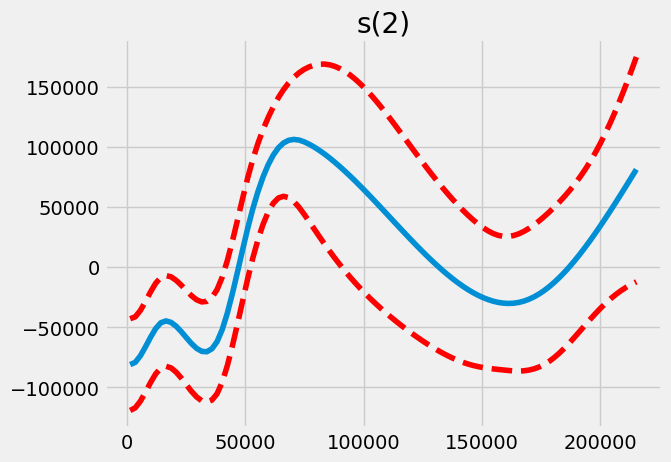

GrLivArea


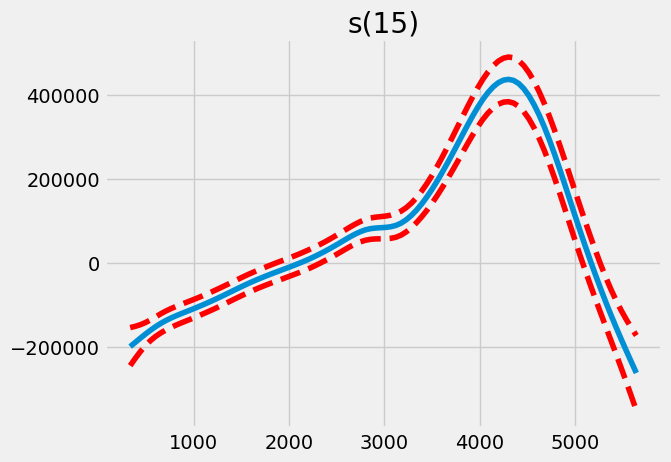

In [17]:
for i, term in enumerate(gam_mod.terms):
    if term.isintercept:
        continue

    x_grid = gam_mod.generate_X_grid(term=i)
    pdep, confi = gam_mod.partial_dependence(term=i, X=x_grid, width=0.95)

    feature_name = X_train.columns[term.feature]
    print(feature_name)

    plt.figure()
    plt.plot(x_grid[:, term.feature], pdep)
    plt.plot(x_grid[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

## Your Turn!

Pick two other variables from the dataset and try model their relationship with the house price using a GAM.

In [34]:
# YOUR CODE GOES HERE
gam_mod_01 = LinearGAM(s(4, spline_order=3) + s(5, spline_order=3))
gam_mod_01.fit(X_train, y_train)

gam_mod_02 = LinearGAM(s(get_index("PoolArea"), spline_order=3) + s(5, spline_order=3))
gam_mod_02.fit(X_train, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(31) + s(5) + intercept, 
   tol=0.0001, verbose=False)

In [20]:
gam_mod_01.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     22.3412
Link Function:                     IdentityLink Log Likelihood:                                -53687.1863
Number of Samples:                         2344 AIC:                                            107421.055
                                                AICc:                                          107421.5449
                                                GCV:                                        3593675551.174
                                                Scale:                                      3532074386.599
                                                Pseudo R-Squared:                                   0.4116
Feature Function                  Lam

In [26]:
np.sqrt(gam_mod_01.statistics_['GCV'])


59947.27309205971

In [35]:
np.sqrt(gam_mod_02.statistics_['GCV'])

59913.87685315164

OverallCond


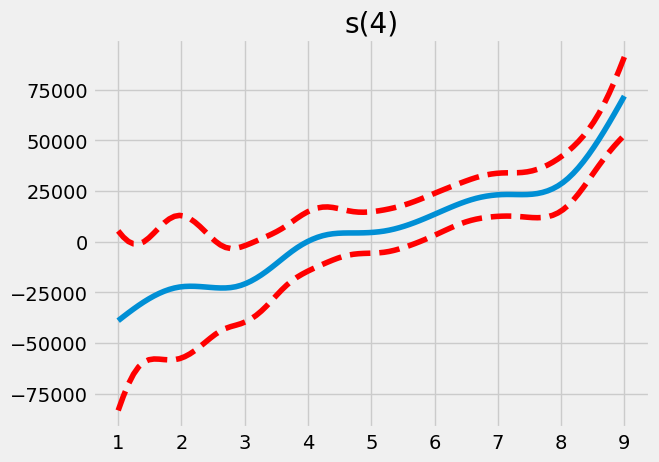

YearBuilt


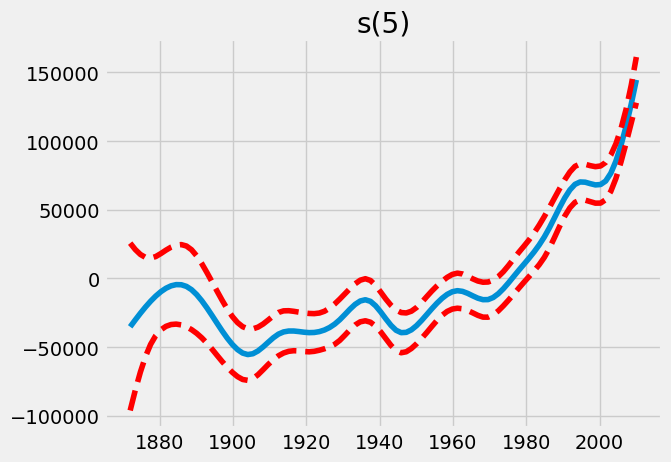

In [22]:
for i, term in enumerate(gam_mod_01.terms):
    if term.isintercept:
        continue

    x_grid = gam_mod_01.generate_X_grid(term=i)
    pdep, confi = gam_mod_01.partial_dependence(term=i, X=x_grid, width=0.95)

    feature_name = X_train.columns[term.feature]
    print(feature_name)

    plt.figure()
    plt.plot(x_grid[:, term.feature], pdep)
    plt.plot(x_grid[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

PoolArea


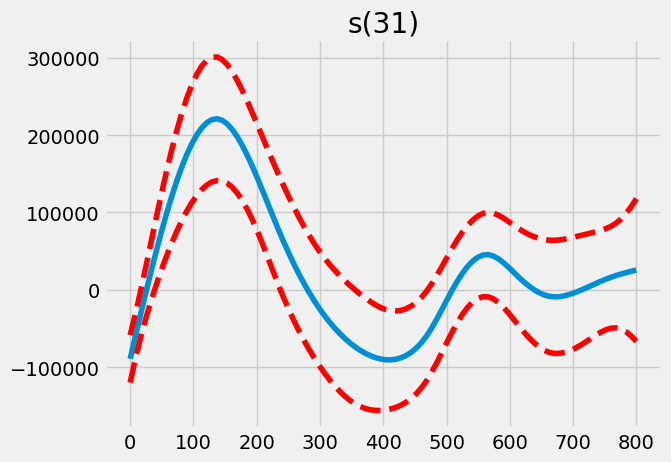

YearBuilt


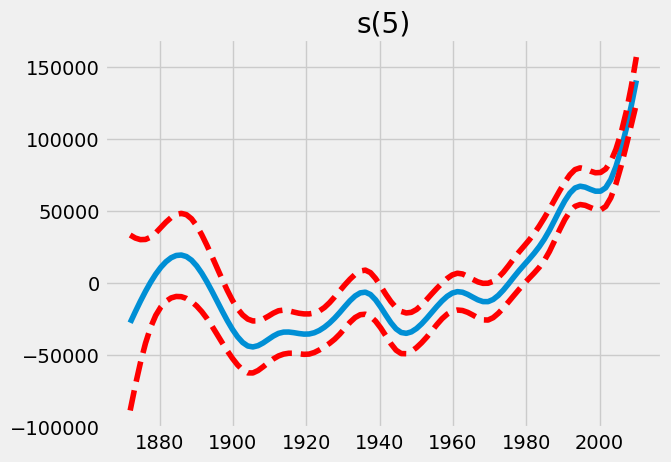

In [36]:
for i, term in enumerate(gam_mod_02.terms):
    if term.isintercept:
        continue

    x_grid = gam_mod_02.generate_X_grid(term=i)
    pdep, confi = gam_mod_02.partial_dependence(term=i, X=x_grid, width=0.95)

    feature_name = X_train.columns[term.feature]
    print(feature_name)

    plt.figure()
    plt.plot(x_grid[:, term.feature], pdep)
    plt.plot(x_grid[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

## Tune the Smoothness Penalty

For fitting the model above, we have used the default value for the smoothing parameter lambda.

In [37]:
print(gam_mod.lam)

[[0.6], [0.6]]


Let’s perform a grid-search over multiple lambda values to see if we can improve our model. We will search for the model with the lowest generalized cross-validation (GCV) score. Let’s try 20 values for each smoothing parameter, resulting in a total of 20*20 = 100 points in our grid.

In [38]:
lam = np.logspace(-10, 10, 20)
lams = [lam] * 2

gam_mod.gridsearch(X_train, y_train, lam=lams)


100% (400 of 400) |######################| Elapsed Time: 0:00:24 Time:  0:00:24


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(2) + s(15) + intercept, 
   tol=0.0001, verbose=False)

In [39]:
gam_mod.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     23.4204
Link Function:                     IdentityLink Log Likelihood:                                -53018.3243
Number of Samples:                         2344 AIC:                                           106085.4894
                                                AICc:                                          106086.0249
                                                GCV:                                       2703824790.1587
                                                Scale:                                     2655240196.5116
                                                Pseudo R-Squared:                                   0.5579
Feature Function                  Lam

Calculate the RMSE based on the GCV error. As we can see, the tuning improved our model slightly.

In [40]:
np.sqrt(gam_mod.statistics_['GCV'])

51998.31526269592

Finally, let's visualize the effect of the tuning on the learned relationships.

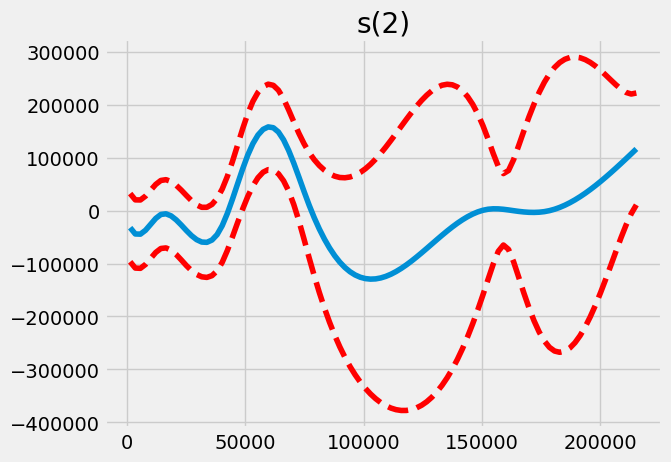

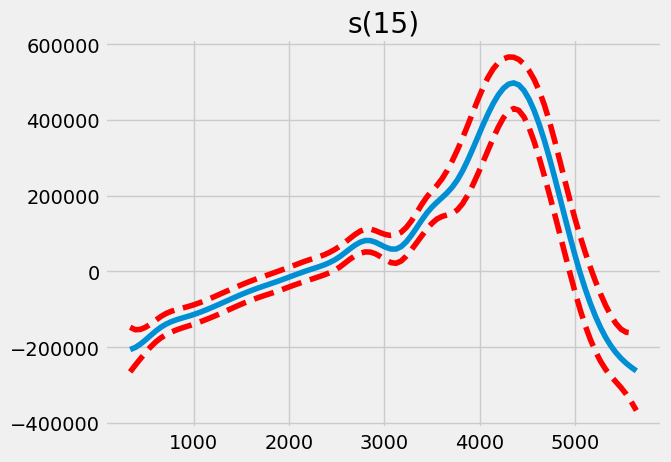

In [41]:
for i, term in enumerate(gam_mod.terms):
    if term.isintercept:
        continue

    x_grid = gam_mod.generate_X_grid(term=i)
    pdep, confi = gam_mod.partial_dependence(term=i, X=x_grid, width=0.95)

    plt.figure()
    plt.plot(x_grid[:, term.feature], pdep)
    plt.plot(x_grid[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()